In [1]:
# Obtaining Dataset
! wget https://data.mendeley.com/datasets/wmy84gzngw/1/files/b63daee9-78de-4122-8475-9b3aa22ffd64/us-dataset.zip?dl=1
! unzip us-dataset.zip?dl=1
! mv originals dataset

--2020-06-04 17:57:20--  https://data.mendeley.com/datasets/wmy84gzngw/1/files/b63daee9-78de-4122-8475-9b3aa22ffd64/us-dataset.zip?dl=1
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/593779a5-2510-4e2d-adeb-71bdcf69a5f4 [following]
--2020-06-04 17:57:21--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/593779a5-2510-4e2d-adeb-71bdcf69a5f4
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.53.211
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.53.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32643

In [3]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

Using TensorFlow backend.


In [0]:
# Dataset Preparation
import os
import random
import shutil

os.chdir('dataset/')
os.mkdir('train/')
os.mkdir('train/benign')
os.mkdir('train/malignant')
os.mkdir('validation/')
os.mkdir('validation/benign')
os.mkdir('validation/malignant')

benign_samples = os.listdir('benign')
random.shuffle(benign_samples)
train_benign = benign_samples[:int(0.8*len(benign_samples))]
val_benign = benign_samples[int(0.8*len(benign_samples)):]

for f in train_benign:
  shutil.move('benign/'+f, 'train/benign')
for f in val_benign:
  shutil.move('benign/'+f, 'validation/benign')
os.rmdir('benign')

malignant_samples = os.listdir('malignant')
random.shuffle(malignant_samples)
train_malignant = malignant_samples[:int(0.8*len(malignant_samples))]
val_malignant = malignant_samples[int(0.8*len(malignant_samples)):]

for f in train_malignant:
  shutil.move('malignant/'+f, 'train/malignant')
for f in val_malignant:
  shutil.move('malignant/'+f, 'validation/malignant')
os.rmdir('malignant')

In [4]:
# Data Pre-Processing
IMG_HEIGHT = 30
IMG_WIDTH = 40

datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             fill_mode='nearest')

training_set = datagen.flow_from_directory("train",
                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                           batch_size=32,
                                           color_mode="grayscale",
                                           class_mode='binary')

validation_set = datagen.flow_from_directory("validation",
                                             target_size=(IMG_HEIGHT, IMG_WIDTH),
                                             batch_size=32,
                                             color_mode="grayscale",
                                             class_mode='binary')
label_map = training_set.class_indices #{'benign': 0, 'malignant': 1}

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


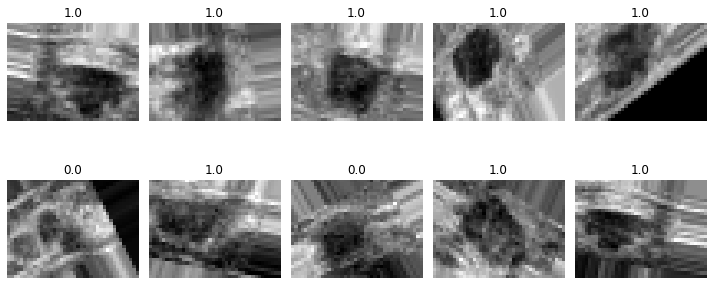

In [5]:
# Plotting 2x5 Images from Training Set
sample_images, sample_labels = next(training_set)
fig, axes = plt.subplots(2, 5, figsize=(10,5))
axes = axes.flatten()
for img, label, ax in zip(sample_images[:10], sample_labels[:10], axes):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.axis('off')
    ax.set_title(label)
plt.tight_layout()
plt.show()

In [6]:
# Deep Learning Model
model = Sequential()
model.add(Conv2D(64, (3, 3), input_shape=(IMG_HEIGHT, IMG_WIDTH, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 38, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 19, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 17, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)              

In [7]:
# Model Training
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(training_set,
                    steps_per_epoch = 10000 // 32,
                    epochs = 30,
                    validation_data = validation_set,
                    validation_steps = 1000 // 32)


Epoch 1/30
312/312 [==============================] - 12s 39ms/step - loss: 0.7873 - accuracy: 0.5711 - val_loss: 0.6522 - val_accuracy: 0.6304
Epoch 2/30
312/312 [==============================] - 10s 33ms/step - loss: 0.6623 - accuracy: 0.6066 - val_loss: 0.6053 - val_accuracy: 0.6432
Epoch 3/30
312/312 [==============================] - 10s 33ms/step - loss: 0.6388 - accuracy: 0.6297 - val_loss: 0.5936 - val_accuracy: 0.6611
Epoch 4/30
312/312 [==============================] - 10s 33ms/step - loss: 0.6297 - accuracy: 0.6360 - val_loss: 0.7284 - val_accuracy: 0.6615
Epoch 5/30
312/312 [==============================] - 10s 33ms/step - loss: 0.6027 - accuracy: 0.6576 - val_loss: 0.6184 - val_accuracy: 0.6854
Epoch 6/30
312/312 [==============================] - 10s 33ms/step - loss: 0.5909 - accuracy: 0.6750 - val_loss: 0.5041 - val_accuracy: 0.6979
Epoch 7/30
312/312 [==============================] - 10s 33ms/step - loss: 0.5583 - accuracy: 0.6944 - val_loss: 0.5618 - val_accuracy:

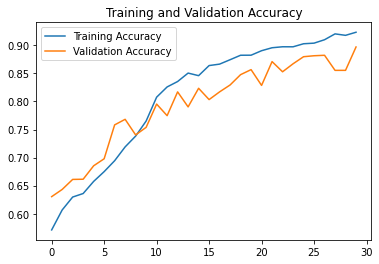

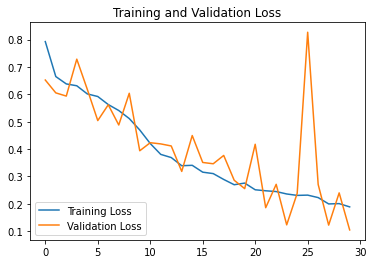

In [8]:
# Model Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(30)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()